In [1]:
import os
import gseapy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process
import mygene
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import requests

/opt/miniforge/envs/drug_environment2/lib/python3.10/site-packages/bioservices/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Drug-»Disease dataset preprocessing

In [11]:
#reading the dataset from a csv file
#this csv file is a dataset about drug-target information containting 54851 records and 10 attributes
#key parts of this initial dataset is the list of diseases, corresponding drugs effective againts them and the interaction scores showing how effective is the drug against this disease
#downloaded from http://zhanglab.hzau.edu.cn/GETdb/page/download.jsp
DrugTargetInfo = pd.read_csv("/home/alexandrarolya/Pablo/GETdb_drugTargetInfo.csv")
print(DrugTargetInfo.shape)
print(DrugTargetInfo.head())

(54851, 10)
       drug_name       drug_type  \
0   zinc acetate  small molecule   
1         copper  small molecule   
2           zinc  small molecule   
3  zinc chloride  small molecule   
4    ocriplasmin         biotech   

                                         drug_MeSHID  \
0  Growth Disorders[MeSHID:D006130],Diarrhea[MeSH...   
1  Disruptive, Impulse Control, and Conduct Disor...   
2  Growth Disorders[MeSHID:D006130],Diarrhea[MeSH...   
3  Serum[MeSHID:D044967],Syndrome[MeSHID:D013577]...   
4  Tissue Adhesions[MeSHID:D000267],Disruptive, I...   

                drug_status            target_name gene_name target_type  \
0  approved,investigational  alpha-1b-glycoprotein      A1BG         NaN   
1  approved,investigational  alpha-1b-glycoprotein      A1BG         NaN   
2  approved,investigational  alpha-1b-glycoprotein      A1BG         NaN   
3  approved,investigational  alpha-2-macroglobulin       A2M         NaN   
4                  approved  alpha-2-macroglobulin    

## Initial filtering

In [12]:
# Keep only rows with non-null interaction scores
dtf = DrugTargetInfo[DrugTargetInfo['interaction_score'].notna()].copy()
print(f"Rows with valid interaction score: {dtf.shape[0]}")
# Standartizing gene names
dtf['gene_name'] = dtf['gene_name'].str.upper()
#extracting breast cancer related genes
bc_dtf = dtf[dtf['drug_MeSHID'].str.contains('breast', case=False, na=False)]
print(f"Breast cancer–related drug-target pairs: {bc_dtf.shape[0]}")
print(bc_dtf[['drug_name', 'gene_name', 'interaction_score', 'drug_MeSHID']].head())

Rows with valid interaction score: 10543
Breast cancer–related drug-target pairs: 371
      drug_name gene_name  interaction_score  \
81   tariquidar     ABCB1               0.66   
84  tesmilifene     ABCB1               0.11   
86   tariquidar     ABCB1               0.66   
94   tariquidar     ABCB1               0.66   
95   tariquidar     ABCB1               0.66   

                                          drug_MeSHID  
81  Malignant neoplasm of breast[MeSHID:D001943],M...  
84  Malignant Neoplasms[MeSHID:D009369],Disruptive...  
86  Malignant neoplasm of breast[MeSHID:D001943],M...  
94  Malignant neoplasm of breast[MeSHID:D001943],M...  
95  Malignant neoplasm of breast[MeSHID:D001943],M...  


In [13]:
# Reset index to start from 1 (optional: drop old index)
bc_dtf_reset = bc_dtf.reset_index(drop=True)
bc_dtf_reset.index += 1  # Start numbering rows at 1

# Save to CSV with the new index as a column in the saved file
bc_dtf_reset.to_csv("DrugName_BreastCancer.csv", index_label="RowNumber")

print("Saved filtered breast cancer drug-target data to 'DrugName_BreastCancer.csv'")

Saved filtered breast cancer drug-target data to 'DrugName_BreastCancer.csv'


## Filtered dataset

Since the initial dataset was way too complex and showed too much data in one row and i have separated all the MeSH_id-s in seperate rows in order to then properly extract the diseases I am curious about

In [14]:
#Split the 'drug_MeSHID' string by comma into lists
bc_dtf['MeSH_list'] = bc_dtf['drug_MeSHID'].str.split(',')
#Explode the list of MeSH IDs into separate rows
bc_dtf_expanded = bc_dtf.explode('MeSH_list').reset_index(drop=True)
#Remove leading/trailing whitespace in the newly created 'MeSH_list' column
bc_dtf_expanded['MeSH_list'] = bc_dtf_expanded['MeSH_list'].str.strip()
#Drop the original 'drug_MeSHID' column
bc_dtf_expanded = bc_dtf_expanded.drop(columns=['drug_MeSHID'])
#Save this expanded dataframe—each MeSH ID in its own row
#Reset index starting from 1 as per your previous request
bc_dtf_expanded = bc_dtf_expanded.reset_index(drop=True)
bc_dtf_expanded.index += 1
# Rename index column for clarity
bc_dtf_expanded.to_csv("DrugName_BreastCancer_ExpandedMeSH.csv", index_label="RowNumber")
print(f"Expanded table saved with {bc_dtf_expanded.shape[0]} rows, one MeSH ID per row.")

Expanded table saved with 3521 rows, one MeSH ID per row.


/tmp/ipykernel_59517/3875924426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_dtf['MeSH_list'] = bc_dtf['drug_MeSHID'].str.split(',')


Here i select the disease i want to dive into -» in this case it is a breast cancer

In [15]:
df = pd.read_csv("DrugName_BreastCancer_ExpandedMeSH.csv")
cols = ["RowNumber", "MeSH_list", "drug_name", "target_name", "gene_name", "interaction_score"]
df = df[cols]
df = df.rename(columns={
    "RowNumber": "old_row_number",
    "MeSH_list": "mesh_id", #other columns are unchanged
})
bc_only = df[df["mesh_id"].str.contains("breast", case=False, na=False)] #filtering for breast terms

bc_only = bc_only.reset_index(drop=True)
bc_only.index += 1

bc_only.to_csv("UPD_DrugTarget_BreastCancer.csv", index=False) #saving without index column
print(f"Saved breast cancer specific data with neat, consistent columns to UPD_DrugTarget_BreastCancer.csv")    
print(f"Created table size: {bc_only.shape[0]} rows, {bc_only.shape[1]} columns")
print(bc_only.head())

Saved breast cancer specific data with neat, consistent columns to UPD_DrugTarget_BreastCancer.csv
Created table size: 458 rows, 6 columns
   old_row_number                                       mesh_id    drug_name  \
1               1  Malignant neoplasm of breast[MeSHID:D001943]   tariquidar   
2              12  Malignant neoplasm of breast[MeSHID:D001943]  tesmilifene   
3              13  Malignant neoplasm of breast[MeSHID:D001943]   tariquidar   
4              20  Malignant neoplasm of breast[MeSHID:D001943]   tariquidar   
5              27  Malignant neoplasm of breast[MeSHID:D001943]   tariquidar   

                      target_name gene_name  interaction_score  
1  multidrug resistance protein 1     ABCB1               0.66  
2                p-glycoprotein 1     ABCB1               0.11  
3  multidrug resistance protein 1     ABCB1               0.66  
4                p-glycoprotein 1     ABCB1               0.66  
5                p-glycoprotein 1     ABCB1            

In order to be sure, that the extracted data is only regarding the breast cancer and not any type of breast related diseases I wish to see the MeSH terms, thus the extracted breast related diseases, and then maybe I will need to exclude some data if it is not cancer related. 

In [16]:
df = pd.read_csv("UPD_DrugTarget_BreastCancer.csv")

# Get the unique mesh_term (or mesh_id) values
unique_mesh_ids = df['mesh_id'].unique()

print(f"Number of unique MeSH terms: {len(unique_mesh_ids)}")
print("List of unique MeSH terms (showing up to 100):")
for i, term in enumerate(unique_mesh_ids[:100]):
    print(f"{i+1}. {term}")

Number of unique MeSH terms: 7
List of unique MeSH terms (showing up to 100):
1. Malignant neoplasm of breast[MeSHID:D001943]
2. Triple Negative Breast Neoplasms[MeSHID:D064726]
3. Breast Fibrocystic Disease[MeSHID:D005348]
4. Breast[MeSHID:D001940]
5. Breast Feeding[MeSHID:D001942]
6. Inflammatory Breast Carcinoma[MeSHID:D058922]
7. Breast Diseases[MeSHID:D001941]


As we see, only 3 of the diseases are actually solely brest cancer related; thus for further analysis, I am only selecting these 3 MeSH-terms. 

In [17]:
df = pd.read_csv("UPD_DrugTarget_BreastCancer.csv")

cancer_terms = [
    "Malignant neoplasm of breast[MeSHID:D001943]",
    "Triple Negative Breast Neoplasms[MeSHID:D064726]",
    "Inflammatory Breast Carcinoma[MeSHID:D058922]"
]

# Filter for strict MeSH terms
cancer_only = df[df["mesh_id"].isin(cancer_terms)].reset_index(drop=True)
cancer_only.index += 1

# Save STRICT file without index column (index=False)
cancer_only.to_csv("UPD_DrugTarget_BreastCancer_STRICT.csv", index=False)

print(f"Filtered dataset saved to UPD_DrugTarget_BreastCancer_STRICT.csv with size: {cancer_only.shape}")
print(cancer_only['mesh_id'].value_counts())

Filtered dataset saved to UPD_DrugTarget_BreastCancer_STRICT.csv with size: (363, 6)
mesh_id
Malignant neoplasm of breast[MeSHID:D001943]        340
Triple Negative Breast Neoplasms[MeSHID:D064726]     21
Inflammatory Breast Carcinoma[MeSHID:D058922]         2
Name: count, dtype: int64


As for now I have a csv file "UPD_DrugTarget_BreastCancer_STRICT.scv" which has the information about the type of disease (MeSH-id), the drug which is effective against this specific disease and the interaction score showing how effective is this drug against this disease.

# Drug2Cell Analysis
## Loading expression matrix and preprocessing the columns:
* cells by genes
* uppercase gene names
* cell IDs as row indexes

In [ ]:
#takes around 1-2 minutes
expr_matrix_raw = pd.read_csv("/share/ulli/HumanBreastCancerPatient1_cell_by_gene.csv")

# Extracting cell names and setzing as index
if 'cell' in expr_matrix_raw.columns:
    metadata = expr_matrix_raw[['cell']].copy()
    expr_matrix = expr_matrix_raw.drop(columns=['cell'])
    expr_matrix.index = metadata['cell']
else:
    expr_matrix = expr_matrix_raw

# Making all gene names uppercase for matching
expr_matrix.columns = expr_matrix.columns.str.upper()

## Loading cleaned Drug-Disease dataset
* keeping "drug_name", "gene_name" and "interaction score"
* uppercase gene names

In [20]:
drug_target_df = pd.read_csv("UPD_DrugTarget_BreastCancer_STRICT.csv")
#I need only these columns: 'drug_name', 'gene_name', 'interaction_score'
drug_target_df['gene_name'] = drug_target_df['gene_name'].str.upper()

## Scoring each drug per cell
* based on the weighted expression of drug target genes -» how strongly each cell expresses the targets of each drug

In [21]:
def score_drugs(expr_matrix, drug_targets):
    """
    Calculate drug target expression scores for each cell.

    Args:
        expr_matrix: DataFrame with cells as rows and uppercase gene names as columns.
        drug_targets: DataFrame with columns [drug_name, gene_name, interaction_score].

    Returns:
        DataFrame with drugs as rows, cells as columns, values are weighted target expression sums.
    """
    drugs = drug_targets['drug_name'].unique()
    cells = expr_matrix.index

    # Initialize DataFrame for scores
    drug_scores = pd.DataFrame(index=drugs, columns=cells, dtype=float)

    # Build mapping to speed up: drug -> list of (gene, score)
    drug_to_targets = drug_targets.groupby('drug_name').apply(
        lambda g: list(zip(g['gene_name'], g['interaction_score']))
    ).to_dict()

    for drug, targets in drug_to_targets.items():
        genes, weights = zip(*targets)
        genes = [g.upper() for g in genes]

        # Filter genes present in expression matrix
        valid_genes = [g for g in genes if g in expr_matrix.columns]
        if not valid_genes:
            # Skip drugs without target genes in expr_matrix
            continue

        # Extract weighted expression and sum
        weights = np.array([weights[genes.index(g)] for g in valid_genes])
        expr_sub = expr_matrix[valid_genes]
        weighted_expr = expr_sub.multiply(weights, axis=1)
        score_per_cell = weighted_expr.sum(axis=1)

        drug_scores.loc[drug] = score_per_cell.values

    # Convert scores to numeric (handle missing)
    drug_scores = drug_scores.apply(pd.to_numeric, errors='coerce')

    return drug_scores

## Running 🏃💨

In [ ]:
#takes around 1-2 minutes
drug_scores = score_drugs(expr_matrix, drug_target_df)

print(drug_scores.shape)  # Number of drugs x number of cells
print(drug_scores.head())

/tmp/ipykernel_59517/2740834893.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  drug_to_targets = drug_targets.groupby('drug_name').apply(


(143, 713121)
cell         0       1       2       3       4       5       6       7       \
tariquidar      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
tesmilifene     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
bosutinib      7.02    1.17    1.17    2.34     0.0    1.17    1.17    5.85   
dcc-2036       0.00    0.00    0.00    0.00     0.0    0.00    0.00    0.00   
aderbasib       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

cell         8       9       ...  713111  713112  713113  713114  713115  \
tariquidar      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
tesmilifene     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
bosutinib      4.68     0.0  ...    2.34    3.51     0.0    2.34     0.0   
dcc-2036       0.00     0.0  ...    0.00    0.00     0.0    0.00     0.0   
aderbasib       NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   

cell         713116  713117  713118  713119  713120  


__At this stage the data does not "know" which cell belongs to which subtype__ <br>
__The MeSH terms describe which drugs are associated with those diseases -» this infromation applies per drug, not per cell__

## Filtering the NaN data

In [23]:
# Remove drugs where all scores are NaN
drug_scores_filtered = drug_scores.dropna(how='all')
print(f"Filtered drug scores shape after removing drugs with all NaNs: {drug_scores_filtered.shape}")

Filtered drug scores shape after removing drugs with all NaNs: (66, 713121)


__Now I have a matrix called "drug_scores_filtered":__ <br>
each row = one drug <br>
each column = once single cell singel-cell RNA-seq <br>
values = each entry is a weighted sum of drug"s target genes" expression in that cell -» weigted by "interaction score" <br>

__Each number tells: for a given drug and a given cell, how “targetable” that cell is to that drug, in the sense that it highly expresses the genes/proteins that the drug is known to interact with.__

# __If I treat this tumor or tissue with Drug X, how much of it is theoretically “druggable”?__

## Summarizing scores

In [24]:
# Mean score per drug (across all cells)
drug_mean_scores = drug_scores_filtered.mean(axis=1).sort_values(ascending=False)
# Max score per drug (shows each drug's best potential hit)
drug_max_scores = drug_scores_filtered.max(axis=1).sort_values(ascending=False)

## Visualizing top drugs by mean score

## Showing top drugs

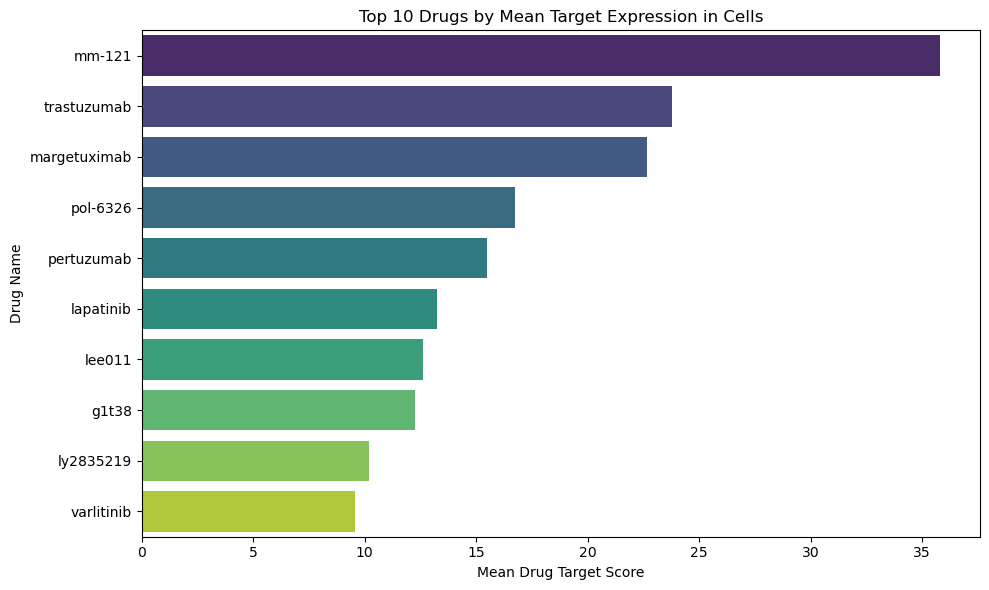

In [27]:
drug_max_scores = drug_scores_filtered.max(axis=1).sort_values(ascending=False)

top10_mean = drug_mean_scores.head(10)

# Convert the Series to a DataFrame for easy use with hue
df = pd.DataFrame({
    'Drug Name': top10_mean.index,
    'Mean Drug Target Score': top10_mean.values
})

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Mean Drug Target Score',
    y='Drug Name',
    hue='Drug Name',                
    data=df,
    palette='viridis',
    legend=False                    
)
plt.xlabel("Mean Drug Target Score")
plt.ylabel("Drug Name")
plt.title("Top 10 Drugs by Mean Target Expression in Cells")
plt.tight_layout()
plt.show()

In [28]:
print("Top drugs by mean targetability:")
print(top10_mean)

drug_mean_scores.to_csv("DrugTarget2cell_Drug_Ranking_Mean.csv")
drug_max_scores.to_csv("DrugTarget2cell_Drug_Ranking_Max.csv")

Top drugs by mean targetability:
mm-121          35.798636
trastuzumab     23.785497
margetuximab    22.652854
pol-6326        16.733455
pertuzumab      15.479450
lapatinib       13.234511
lee011          12.593070
g1t38           12.276789
ly2835219       10.186286
varlitinib       9.561961
dtype: float64


In [29]:
print("Top 10 drugs by mean target expression:")
print(drug_mean_scores.head(10))

print("Top 10 drugs by max target expression:")
print(drug_max_scores.head(10))

drug_mean_scores.to_csv("DrugTarget2cell_Drug_Ranking_Mean.csv")
drug_max_scores.to_csv("DrugTarget2cell_Drug_Ranking_Max.csv")

Top 10 drugs by mean target expression:
mm-121          35.798636
trastuzumab     23.785497
margetuximab    22.652854
pol-6326        16.733455
pertuzumab      15.479450
lapatinib       13.234511
lee011          12.593070
g1t38           12.276789
ly2835219       10.186286
varlitinib       9.561961
dtype: float64
Top 10 drugs by max target expression:
mm-121          1782.90
bavencio        1074.15
trastuzumab      803.25
pol-6326         802.62
margetuximab     765.00
as-1402          636.40
pertuzumab       522.75
atezolizumab     477.00
g1t38            438.05
lapatinib        415.44
dtype: float64


## Distribution of a single drug's target score across all cells

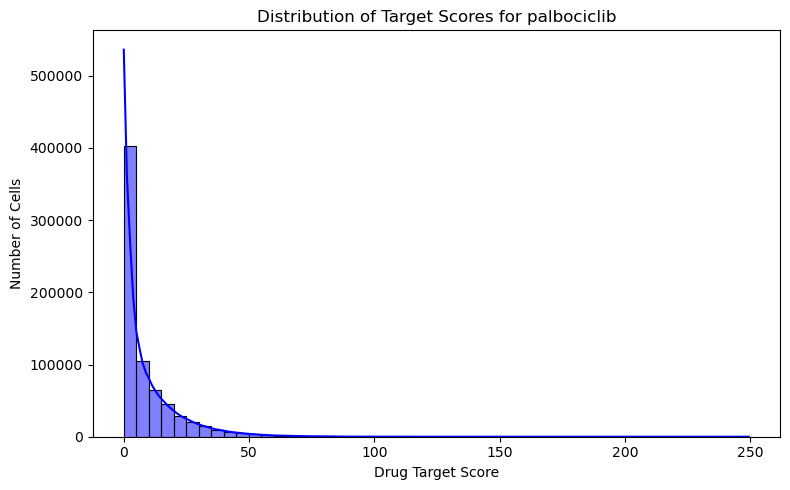

In [30]:
# Replace 'drug_scores_filtered' with your actual DataFrame
drug_name = 'palbociclib'  # Example drug name, change as needed

if drug_name in drug_scores_filtered.index:
    scores = drug_scores_filtered.loc[drug_name].dropna()
    plt.figure(figsize=(8, 5))
    sns.histplot(scores, bins=50, kde=True, color='blue')
    plt.title(f'Distribution of Target Scores for {drug_name}')
    plt.xlabel('Drug Target Score')
    plt.ylabel('Number of Cells')
    plt.tight_layout()
    plt.show()
else:
    print(f"Drug {drug_name} not found in your score matrix.")


Thoughts? <br>
- A bunch of cells with a low targetability score, but there is a subset of cells, that are highly expresses. These cells could be rare cell types? 
- Seems like, this is quite logical? -» most of the cells cannnot be ideal target for any one drug -» but, subpopulations can be hhgly "druggable+ by some kind of specific compounds
- if i could somehow identify which cell types or clusters corrrespond to the high-scoring ccells I could understand which tumor parts Pablo may be most effective agains -» HOW?

## Top drugs in each subtype

Top drugs per breast cancer subtype:
Malignant neoplasm of breast[MeSHID:D001943]: ['denosumab', 'arcitumomab', 'bavencio', 'custirsen', 'as-1402']
Triple Negative Breast Neoplasms[MeSHID:D064726]: ['sar-566658', 'atezolizumab', 'eft508', 'bemcentinib', 'nivolumab']
Inflammatory Breast Carcinoma[MeSHID:D058922]: ['palbociclib']


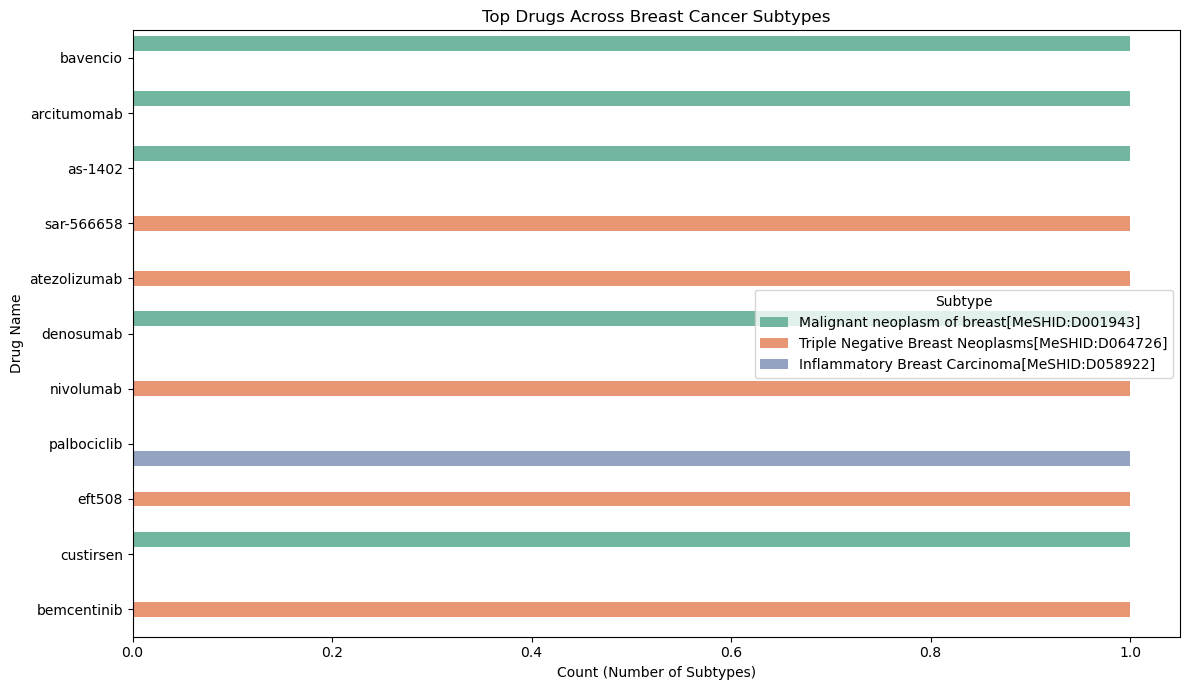

In [31]:
df = pd.read_csv("UPD_DrugTarget_BreastCancer_STRICT.csv")
df['drug_name'] = df['drug_name'].str.lower()

# Group by subtype and get the top N drugs per subtype based on interaction_score
top_drugs_per_subtype = {}
top_n = 5  # change this to select your desired top N

for subtype in df['mesh_id'].unique():
    sub_df = df[df['mesh_id'] == subtype]
    # Get mean (or max) score per drug for this subtype
    drug_scores = sub_df.groupby('drug_name')['interaction_score'].mean()
    # Sort and take the top N
    top_drugs = drug_scores.sort_values(ascending=False).head(top_n).index.tolist()
    top_drugs_per_subtype[subtype] = top_drugs

print("Top drugs per breast cancer subtype:")
for subtype, drugs in top_drugs_per_subtype.items():
    print(f"{subtype}: {drugs}")


all_drugs = set()
plot_data = []
for subtype, drugs in top_drugs_per_subtype.items():
    for d in drugs:
        plot_data.append({'Subtype': subtype, 'Drug': d})
        all_drugs.add(d)

df_plot = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 7))
sns.countplot(data=df_plot, y='Drug', hue='Subtype', dodge=True, palette='Set2', order=list(all_drugs))
plt.title('Top Drugs Across Breast Cancer Subtypes')
plt.xlabel('Count (Number of Subtypes)')
plt.ylabel('Drug Name')
plt.legend(title='Subtype')
plt.tight_layout()
plt.show()

Thoughts? 
- many drugs are top hits of only a single subtypw, some of them are only among the top in the "malignant neoplams" category 
- my candidate drugs are highly specific to the breast cancer subtype 

## Overlap counts of top drugs

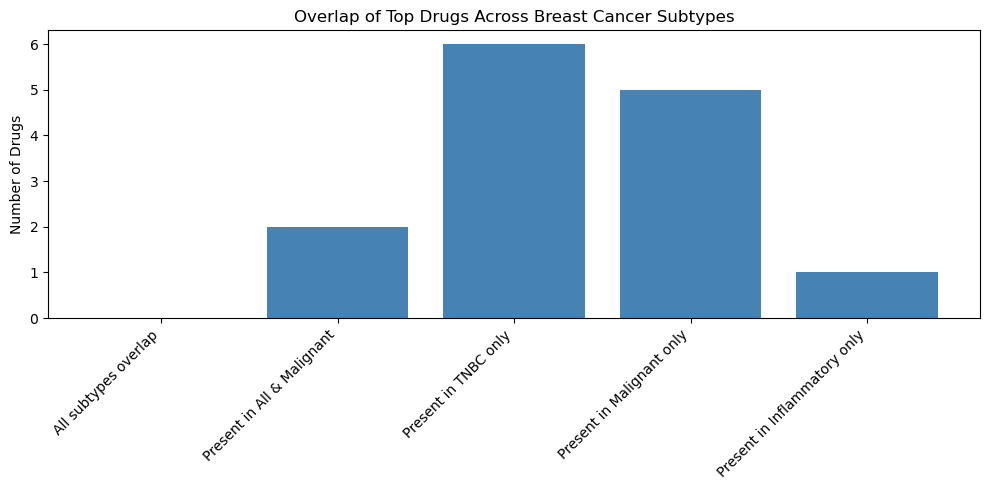

In [32]:
labels = ['All subtypes overlap', 'Present in All & Malignant', 'Present in TNBC only', 'Present in Malignant only', 'Present in Inflammatory only']
counts = [0, 2, 6, 5, 1]

plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Drugs')
plt.title('Overlap of Top Drugs Across Breast Cancer Subtypes')
plt.tight_layout()
plt.show()

### Just checking for some specific drugs:)

In [34]:
drug_target_df = pd.read_csv("UPD_DrugTarget_BreastCancer_STRICT.csv")
query = 'palbociclib' # Example drug name, change as needed
matches = drug_target_df[drug_target_df['drug_name'].str.lower().str.contains(query)]

print(f"Found {matches.shape[0]} entries for '{query}':")
print(matches)

Found 6 entries for 'palbociclib':
    old_row_number                                           mesh_id  \
46             538  Triple Negative Breast Neoplasms[MeSHID:D064726]   
47             552      Malignant neoplasm of breast[MeSHID:D001943]   
48             553     Inflammatory Breast Carcinoma[MeSHID:D058922]   
58             612  Triple Negative Breast Neoplasms[MeSHID:D064726]   
59             626      Malignant neoplasm of breast[MeSHID:D001943]   
60             627     Inflammatory Breast Carcinoma[MeSHID:D058922]   

      drug_name                target_name gene_name  interaction_score  
46  palbociclib  cyclin-dependent kinase 4      CDK4               0.71  
47  palbociclib  cyclin-dependent kinase 4      CDK4               0.71  
48  palbociclib  cyclin-dependent kinase 4      CDK4               0.71  
58  palbociclib  cyclin-dependent kinase 6      CDK6               0.54  
59  palbociclib  cyclin-dependent kinase 6      CDK6               0.54  
60  palbociclib 

# Drug synonyms

Since I am using a lot of different databases the names of the drugs could be different, so by implicating the synonym dictionary I tend minimise the chance of getting low quality results.

In [36]:
import requests
from collections import defaultdict
import time

In [37]:
#takes around 2 minutes
def get_chembl_synonyms(drug_name):
    """
    Query ChEMBL API to retrieve synonyms of a drug name.
    Returns a set of synonyms including the original name.
    """
    url = f'https://www.ebi.ac.uk/chembl/api/data/molecule/search.json?q={drug_name}'
    try:
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        data = r.json()
        synonyms = set([drug_name.lower()])  # Include original name
        if 'molecules' in data and len(data['molecules']) > 0:
            for molecule in data['molecules']:
                # Molecule synonyms
                for syn in molecule.get('molecule_synonyms', []):
                    synonyms.add(syn['synonym'].lower())
        return synonyms
    except Exception as e:
        print(f"Warning: Could not fetch synonyms for '{drug_name}': {str(e)}")
        return set([drug_name.lower()])

def build_synonym_dict(drug_names_list):
    """
    For a list of drug names, build a synonym dictionary by querying ChEMBL.
    """
    synonym_dict = defaultdict(set)
    for drug in drug_names_list:
        # Get synonyms from ChEMBL
        syns = get_chembl_synonyms(drug)
        canonical = drug.lower()
        synonym_dict[canonical].update(syns)
        # Be respectful to server; avoid too rapid queries
        time.sleep(0.5)
    return synonym_dict

# Example integration

# Load your filtered ranked drug list (replace with your actual file)
drug_list_df = pd.read_csv('DrugTarget2cell_Drug_Ranking_Mean.csv', index_col=0)
# Extract drug names (index if you saved rankings as Series)
drug_names = drug_list_df.index.tolist()

# Build synonym dictionary automatically via ChEMBL API
syn_dict = build_synonym_dict(drug_names)

# Print a sample of synonyms for verification
for can_name, syns in list(syn_dict.items())[:5]:
    print(f"{can_name} -> {sorted(syns)}")

# You can then use this syn_dict to normalize and map your drug names in downstream analyses.

# Example function to map input drug to canonical form
def map_drug_to_canonical(drug_name, synonym_dict):
    drug_lower = drug_name.lower()
    for canonical, synonyms in synonym_dict.items():
        if drug_lower in synonyms:
            return canonical
    return drug_lower

# Map your ranked list to canonical drug names
drug_list_df['canonical_drug'] = drug_list_df.index.map(lambda d: map_drug_to_canonical(d, syn_dict))

print(drug_list_df.head())

mm-121 -> ['mm-121']
trastuzumab -> ['trastuzumab']
margetuximab -> ['margetuximab']
pol-6326 -> ['pol-6326']
pertuzumab -> ['pertuzumab']
                      0 canonical_drug
mm-121        35.798636         mm-121
trastuzumab   23.785497    trastuzumab
margetuximab  22.652854   margetuximab
pol-6326      16.733455       pol-6326
pertuzumab    15.479450     pertuzumab


After calling this API and creating a dictionary I still see, that some drugs are "underrepresented" and I seems like they don't have any synonyms. However, I know, that they have synonyms. So I created a separate "manual_synonyms" dictionary, which can be manually "updated".

In [38]:
manual_synonyms = {
    'mm-121': ['mm-121', 'seribantumab'],
    'trastuzumab': ['trastuzumab', 'herceptin', 'trastuzumab emtansine', 'trastuzumab-dm1', 'kadcyla'],
    'pol-6326': ['pol-6326', 'balixafortide'],
    'pertuzumab': ['pertuzumab', 'perjeta'],
    'lapatinib': ['lapatinib', 'tykerb', 'tyverb'],
    'lee011': ['lee011', 'dalpiciclib'],
    'g1t38': ['g1t38', 'margetuximab'],
    'azd5363': ['azd5363', 'capivasertib'],
    'tucatinib': ['tucatinib', 'tukysa'],
    'palbociclib': ['palbociclib', 'ibrance'],
    'balixafortide': ['balixafortide'],
    'hki-272': ['hki-272', 'neratinib'],
    'gdc-0068': ['gdc-0068', 'ipatasertib'],
    'ribociclib succinate': ['ribociclib succinate', 'kisqali'],
    'abemaciclib': ['abemaciclib', 'verzenio'],
    'azd8931': ['azd8931', 'sapitinib'],
    'bavencio': ['bavencio', 'avelumab'],
    'sndx-275': ['sndx-275', 'entinostat'],
    'atezolizumab': ['atezolizumab', 'tecentriq'],
    'pd-0325901': ['pd-0325901', 'mirdametinib'],
    'bosutinib': ['bosutinib', 'bosulif'],
    'neratinib': ['neratinib', 'hki-272'],
    'gdc-0032': ['gdc-0032', 'umbralisib'],
    'alpelisib': ['alpelisib', 'piqray'],
    'paclitaxel': ['paclitaxel', 'taxol'],
    'taxol': ['taxol', 'paclitaxel'],
    'xl880': ['xl880', 'foretinib'],
    'gdc-0077': ['gdc-0077', 'abemaciclib'],
    'everolimus': ['everolimus', 'afinitor'],
    'nivolumab': ['nivolumab', 'opdivo'],
    'pembrolizumab': ['pembrolizumab', 'keytruda'],
    'ink128': ['ink128', 'sapanisertib'],
}
print("Manual synonyms with new entries added, ready for integration into your pipeline.")


Manual synonyms with new entries added, ready for integration into your pipeline.


## Comparing drug candidates across all breast cancer and specific subtypes

## Summarising top drugs / Subtype

In [39]:
drug_target_df = pd.read_csv("UPD_DrugTarget_BreastCancer_STRICT.csv")
drug_mean_scores = pd.read_csv("DrugTarget2cell_Drug_Ranking_Mean.csv", index_col=0).squeeze("columns")
# Identifying unique breast cancer subtypes
subtypes = drug_target_df['mesh_id'].unique()
# Finding top 10 drugs overall
top_all = drug_mean_scores.sort_values(ascending=False).head(10).index.tolist()
print("Top drugs for all breast cancer types:")
print(top_all)
# Finding top 10 drugs for each subtype
top_drugs_per_subtype = {}
for subtype in subtypes:
    drugs_in_subtype = drug_target_df[drug_target_df['mesh_id'] == subtype]['drug_name'].unique()
    scores_for_subtype = drug_mean_scores.loc[drug_mean_scores.index.isin(drugs_in_subtype)]
    top_drugs_per_subtype[subtype] = scores_for_subtype.sort_values(ascending=False).head(10).index.tolist()
    print(f"\nTop drugs for {subtype}:")
    print(top_drugs_per_subtype[subtype])
# Finding overlaps and unique drugs per subtype
overlap = set(top_all)
for drugs in top_drugs_per_subtype.values():
    overlap = overlap.intersection(set(drugs))
print(f"\nDrugs common across all compared sets: {sorted(overlap)}")

unique_per_subtype = {}
for subtype, drugs in top_drugs_per_subtype.items():
    others = set(top_all) | set([d for s, dlist in top_drugs_per_subtype.items() if s != subtype for d in dlist])
    unique_per_subtype[subtype] = sorted(set(drugs) - others)
    print(f"\nUnique drugs for {subtype}: {unique_per_subtype[subtype]}")

Top drugs for all breast cancer types:
['mm-121', 'trastuzumab', 'margetuximab', 'pol-6326', 'pertuzumab', 'lapatinib', 'lee011', 'g1t38', 'ly2835219', 'varlitinib']

Top drugs for Malignant neoplasm of breast[MeSHID:D001943]:
['mm-121', 'trastuzumab', 'margetuximab', 'pol-6326', 'pertuzumab', 'lapatinib', 'lee011', 'g1t38', 'ly2835219', 'varlitinib']

Top drugs for Triple Negative Breast Neoplasms[MeSHID:D064726]:
['azd5363', 'palbociclib', 'trilaciclib', 'atezolizumab', 'sar-566658', 'mcs-110', 'enmd-2076', 'nivolumab', 'pembrolizumab', 'tki258']

Top drugs for Inflammatory Breast Carcinoma[MeSHID:D058922]:
['palbociclib']

Drugs common across all compared sets: []

Unique drugs for Malignant neoplasm of breast[MeSHID:D001943]: []

Unique drugs for Triple Negative Breast Neoplasms[MeSHID:D064726]: ['atezolizumab', 'azd5363', 'enmd-2076', 'mcs-110', 'nivolumab', 'pembrolizumab', 'sar-566658', 'tki258', 'trilaciclib']

Unique drugs for Inflammatory Breast Carcinoma[MeSHID:D058922]: []


# DrugSignature2drug Analysis

## Utils

In [40]:
class GeneMatcher:
    def __init__(self, expr_genes, threshold=90):
        """
        Initialize the GeneMatcher with a list of gene names from the expression matrix
        and the fuzzy matching score threshold.
        
        Args:
            expr_genes (list): List of gene names in the expression matrix.
            threshold (int): Fuzzy match score cutoff (default: 90).
        """
        self.expr_genes = expr_genes
        self.threshold = threshold
        self.mg = mygene.MyGeneInfo()

    def get_gene_alias(self, gene):
        """
        Query gene aliases using the MyGeneInfo database.
        
        Args:
            gene (str): The gene symbol to look up.
            
        Returns:
            list or None: List of aliases if found, else None.
        """
        print(f"Querying alias for gene: {gene}")
        gene_info = self.mg.query(gene, fields="alias", species="human")
        gene_alias = None
        if gene_info["hits"]:
            for hit in gene_info["hits"]:
                if "alias" in hit:
                    gene_alias = hit["alias"]
                    if not isinstance(gene_alias, list):
                        gene_alias = [gene_alias]
                    print(f"Found alias for gene {gene}: {gene_alias}")
                    break
        if not gene_alias:
            print(f"No alias found for gene: {gene}")
        return gene_alias

    def match_genes_with_alias(self, gene_list):
        """
        Match a list of input genes to genes in the expression matrix,
        using fuzzy matching and alias lookup if needed.
        
        Args:
            gene_list (list): List of input gene names to be matched.
        
        Returns:
            dict: Mapping from input gene names to matched expression matrix gene names.
        """
        matched_genes = {}

        for gene in gene_list:
            # Try fuzzy matching the gene name directly
            match = process.extractOne(gene, self.expr_genes, score_cutoff=self.threshold)
            if match:
                matched_genes[gene] = match[0]
                print(f"Matched gene {gene} to {match[0]}")
            else:
                # Try matching gene aliases if direct match failed
                gene_alias = self.get_gene_alias(gene)
                if gene_alias:
                    for alias in gene_alias:
                        match = process.extractOne(alias, self.expr_genes, score_cutoff=self.threshold)
                        if match:
                            matched_genes[gene] = match[0]
                            print(f"Matched alias {alias} of gene {gene} to {match[0]}")
                            break
                if gene not in matched_genes:
                    print(f"No match found for gene {gene} or its aliases")
            print("-" * 50)
        return matched_genes

## Preprocessing 

In [41]:
#takes around 2 minutes to run
# Read the gene expression matrix from a CSV file
#this csv file is the dataset about gene expression in breast cancer cells
#it was retreived from: https://info.vizgen.com/ffpe-showcase?submissionGuid=18e2454a-cc07-4faa-93c0-b86ae41762af
expr_matrix = pd.read_csv("/share/ulli/HumanBreastCancerPatient1_cell_by_gene.csv")
print(expr_matrix.shape)
print(expr_matrix.head())

# Extract the "cell" column as metadata
metadata = expr_matrix[["cell"]]

# Drop the "cell" column from the expression matrix
expr_matrix = expr_matrix.drop(columns=["cell"])

# Convert all gene names to uppercase for consistency
expr_matrix.columns = expr_matrix.columns.str.upper()
print(expr_matrix.columns)

# Remove all genes whose names start with "BLANK"
expr_matrix = expr_matrix.loc[:, ~expr_matrix.columns.str.startswith("BLANK")]
print(expr_matrix.shape)

# Get the list of gene names present in the expression matrix
expr_genes = list(expr_matrix.columns)

(713121, 551)
   cell  PDK4  CCL26  CX3CL1  PGLYRP1  CD4  SNAI2  TNFRSF17  ICAM3  TBX21  \
0     0   2.0    0.0     5.0      0.0  0.0    0.0       1.0    0.0    0.0   
1     1   0.0    0.0     0.0      0.0  0.0    0.0       0.0    0.0    0.0   
2     2   1.0    0.0     2.0      0.0  0.0    0.0       0.0    0.0    0.0   
3     3   0.0    0.0     4.0      0.0  0.0    0.0       1.0    0.0    0.0   
4     4   0.0    0.0     0.0      0.0  0.0    0.0       1.0    0.0    0.0   

   ...  Blank-41  Blank-42  Blank-43  Blank-44  Blank-45  Blank-46  Blank-47  \
0  ...       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1  ...       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2  ...       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3  ...       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4  ...       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   Blank-48  Blank-49  Blank-50  
0       

So, what i see, is that a lot of drugs i selected as top drugs for treating BC are not present in the drug-gene dataset. It is challenging to find a bingo: a drug, which is still effective against BC and has a relevant data about drug target signatures. 
Thus, possible solution: 
- the analysis performed earlier to select the best drugs stays as it is
- i use the dataset with drugs and their targets and sort of combine it with that "the most effective drug" database
- once it is combined, i 'extract' those drugs, which are present in both sources
- i create a ranking once more and get a list of top10 drug effective against BC, which have relevant drug-target data 


## Query DGIdb for drug-gene interactions related to BC

I found one source, the DGIdb, which shows me the genes which are targeted by a selected drug.

In [42]:
# Load DGIdb interaction data (adjust file extension if needed)
#file downloaded from: https://dgidb.org/downloads 
dgidb_path = "drug_gene_interactions.tsv"
dgidb_df = pd.read_csv(dgidb_path, sep='\t')

# Preview columns and shape
print(f"Columns in DGIdb  {list(dgidb_df.columns)}")
print(f"Data shape: {dgidb_df.shape}")
print(dgidb_df.head())

# Load your strict drug-target database
strict_path = "UPD_DrugTarget_BreastCancer_STRICT.csv"
strict_df = pd.read_csv(strict_path)

# Normalize column names to lowercase
dgidb_df.columns = dgidb_df.columns.str.lower()
strict_df.columns = strict_df.columns.str.lower()

# Uppercase target genes for uniformity
dgidb_df['gene_name'] = dgidb_df['gene_name'].str.upper()
strict_df['gene_name'] = strict_df['gene_name'].str.upper()

# Lowercase drug names for uniformity
dgidb_df['drug_name'] = dgidb_df['drug_name'].str.lower()
strict_df['drug_name'] = strict_df['drug_name'].str.lower()

# Filter DGIdb to keep interactions where gene is in your strict database (expressed targets)
relevant_genes = set(strict_df['gene_name'].str.upper().unique())
dgidb_filtered = dgidb_df[dgidb_df['gene_name'].isin(relevant_genes)]

print(f"Filtered DGIdb interactions count: {len(dgidb_filtered)}")

# Further, select DGIdb entries targeting antineoplastic and/or approved drugs if needed
dgidb_filtered = dgidb_filtered[(dgidb_filtered['approved'] == True) | (dgidb_filtered['anti_neoplastic'] == True)]

print(f"Filtered DGIdb for approved or antineoplastic drugs count: {len(dgidb_filtered)}")

# Get unique drug names from DGIdb filtered set
dgidb_drugs = set(dgidb_filtered['drug_name'].unique())
print(f"Unique DGIdb drugs after filtering: {len(dgidb_drugs)}")

# Your existing manual synonyms dictionary (extend as needed)
manual_synonyms = {
    'mm-121': ['mm-121', 'seribantumab'],
    'trastuzumab': ['trastuzumab', 'herceptin', 'trastuzumab emtansine', 'trastuzumab-dm1', 'kadcyla'],
    'pol-6326': ['pol-6326', 'balixafortide'],
    'pertuzumab': ['pertuzumab', 'perjeta'],
    'lapatinib': ['lapatinib', 'tykerb', 'tyverb'],
    'lee011': ['lee011', 'dalpiciclib'],
    'g1t38': ['g1t38', 'margetuximab'],
    'azd5363': ['azd5363', 'capivasertib'],
    'tucatinib': ['tucatinib', 'tukysa'],
    'palbociclib': ['palbociclib', 'ibrance'],
    'balixafortide': ['balixafortide'],
    'hki-272': ['hki-272', 'neratinib'],
    'gdc-0068': ['gdc-0068', 'ipatasertib'],
    'ribociclib succinate': ['ribociclib succinate', 'kisqali'],
    'abemaciclib': ['abemaciclib', 'verzenio'],
    'azd8931': ['azd8931', 'sapitinib'],
    'bavencio': ['bavencio', 'avelumab'],
    'sndx-275': ['sndx-275', 'entinostat'],
    'atezolizumab': ['atezolizumab', 'tecentriq'],
    'pd-0325901': ['pd-0325901', 'mirdametinib'],
    'bosutinib': ['bosutinib', 'bosulif'],
    'neratinib': ['neratinib', 'hki-272'],
    'gdc-0032': ['gdc-0032', 'umbralisib'],
    'alpelisib': ['alpelisib', 'piqray'],
    'paclitaxel': ['paclitaxel', 'taxol'],
    'taxol': ['taxol', 'paclitaxel'],
    'xl880': ['xl880', 'foretinib'],
    'gdc-0077': ['gdc-0077', 'abemaciclib'],
    'everolimus': ['everolimus', 'afinitor'],
    'nivolumab': ['nivolumab', 'opdivo'],
    'pembrolizumab': ['pembrolizumab', 'keytruda'],
    'ink128': ['ink128', 'sapanisertib'],
}

# Build full synonym dictionary mapping lowercase drug to set of synonyms
from collections import defaultdict

synonym_dict = defaultdict(set)

for canonical, syns in manual_synonyms.items():
    lower_canon = canonical.lower()
    synonym_dict[lower_canon].update([s.lower() for s in syns])

# Add the canonical name itself if missing
for drug in list(synonym_dict.keys()):
    synonym_dict[drug].add(drug)

# Function to check if any synonym of drug is in the DGIdb drugs
def drug_in_dgidb(drug, dgidb_set, syn_dict):
    drug = drug.lower()
    syns = syn_dict.get(drug, {drug})
    return any(s in dgidb_set for s in syns)

dgidb_drug_set = set(dgidb_filtered['drug_name'].unique())
strict_drug_set = set(strict_df['drug_name'].unique())

common_drugs_with_synonyms = {drug for drug in strict_drug_set if drug_in_dgidb(drug, dgidb_drug_set, synonym_dict)}

print(f"Number of drugs common to strict DB and DGIdb after considering synonyms: {len(common_drugs_with_synonyms)}")
print(f"Sample drugs: {list(common_drugs_with_synonyms)[:10]}")

# Save or pass common_drugs_with_synonyms forward for drugSignature2cell or other analyses

Columns in DGIdb  ['gene_claim_name', 'gene_concept_id', 'gene_name', 'interaction_source_db_name', 'interaction_source_db_version', 'interaction_type', 'interaction_score', 'drug_claim_name', 'drug_concept_id', 'drug_name', 'approved', 'immunotherapy', 'anti_neoplastic']
Data shape: (98239, 13)
  gene_claim_name gene_concept_id gene_name interaction_source_db_name  \
0          CYP2D6       hgnc:2625    CYP2D6                        DTC   
1           PPARG       hgnc:9236     PPARG                        DTC   
2           ATAD5      hgnc:25752     ATAD5                        DTC   
3            RGS4      hgnc:10000      RGS4                        DTC   
4           MAPK1       hgnc:6871     MAPK1                        DTC   

  interaction_source_db_version interaction_type  interaction_score  \
0                        9/2/20              NaN           0.017709   
1                        9/2/20              NaN           0.840123   
2                        9/2/20              

In [43]:
print(strict_df.columns)

Index(['old_row_number', 'mesh_id', 'drug_name', 'target_name', 'gene_name',
       'interaction_score'],
      dtype='object')


At this point I: 
- Loaded your strict breast cancer drug-target database,
- Filtered the DGIdb dataset to drugs targeting relevant genes, approved or antineoplastic,
- Incorporated drug synonyms to broaden matching beyond exact names

## Extracting top 10 drugs from filtered database

In [44]:
from collections import defaultdict

synonym_dict = defaultdict(set)
for canonical, syns in manual_synonyms.items():
    lower_canon = canonical.lower()
    synonym_dict[lower_canon].update([s.lower() for s in syns])
for drug in list(synonym_dict.keys()):
    synonym_dict[drug].add(drug)

# Create sets of drugs for matching
dgidb_drug_set = set(dgidb_filtered['drug_name'].unique())
strict_drug_set = set(strict_df['drug_name'].unique())

def drug_in_dgidb(drug, dgidb_set, syn_dict):
    drug = drug.lower()
    syns = syn_dict.get(drug, {drug})
    return any(s in dgidb_set for s in syns)

# Define common_drugs_with_synonyms and its list
common_drugs_with_synonyms = {drug for drug in strict_drug_set if drug_in_dgidb(drug, dgidb_drug_set, synonym_dict)}
common_drugs_list = list(common_drugs_with_synonyms)

# Normalize drug_scores index and common_drugs_list for matching
normalized_common_drugs = [d.strip().lower() for d in common_drugs_list]
drug_scores_norm = drug_scores.rename(index=lambda x: x.strip().lower())

# Filter the normalized drug_scores by normalized common drugs
drug_mean_scores_filtered = drug_scores_norm.loc[
    [d for d in normalized_common_drugs if d in drug_scores_norm.index]]

# Get top 10 drugs by mean target expression
top_10_drugs_by_expr = drug_mean_scores_filtered.sort_values(ascending=False).head(10)

# Print results
print(f"Number of drugs in common_drugs_list: {len(common_drugs_list)}")
print(f"Number of drugs in drug_scores index: {len(drug_scores.index)}")
print(f"Number of drugs overlap after normalization: {len(drug_mean_scores_filtered)}")
print("Top 10 drugs by mean target expression (drug scores) after normalization:")
print(top_10_drugs_by_expr)


Number of drugs in common_drugs_list: 72
Number of drugs in drug_scores index: 1
Number of drugs overlap after normalization: 1
Top 10 drugs by mean target expression (drug scores) after normalization:
drug_name
palbociclib    0.625
Name: interaction_score, dtype: float64


### I want this list to be ranked based on their interaction score, also i want to see the synonyms of these drugs

In [45]:
# Normalize the common drugs list and drug_scores index for consistent matching
normalized_common_drugs = [d.strip().lower() for d in common_drugs_list]
drug_scores.index = drug_scores.index.str.strip().str.lower()

# Filter drug_scores Series to only the drugs in your normalized common drug list
drug_scores_filtered = drug_scores.loc[drug_scores.index.intersection(normalized_common_drugs)]

# Get top 10 drugs by mean target expression (drug scores)
top_10_drugs_by_expr = drug_scores_filtered.sort_values(ascending=False).head(10)

print("Top 10 drugs selected for drugSignature2cell analysis (ranked by expression-based drug scores):")
print(top_10_drugs_by_expr)

# Optionally print synonyms for these top drugs
print("\nSynonyms for top drugs:")
for drug in top_10_drugs_by_expr.index:
    syns = synonym_dict.get(drug, [drug])
    print(f"{drug}: {', '.join(sorted(syns))}")

Top 10 drugs selected for drugSignature2cell analysis (ranked by expression-based drug scores):
drug_name
palbociclib    0.625
Name: interaction_score, dtype: float64

Synonyms for top drugs:
palbociclib: ibrance, palbociclib


Interaction Score = score of how good is the lock and key between drug and gene.(Reliable scientific evidence for drug-target interaction.)

Drug Score = how many locks are present and unlocked in your cells, weighted by the lock-key fit.(How many targets the drug can affect in your specific patient’s cells.)

So one drug it is: __Palbociclib__, or how I call it - Pablo, the smuggler (because he is a smuggler of a drug into the cells:)

## Palbociclib - selected drug

In [46]:
palbo_df = pd.read_csv("Palbociclib_Drug_Gene.tsv", sep='\t')
# downloaded from here: https://dgidb.org/results?searchType=drug&searchTerms=PALBOCICLIB

# Normalizing gene names to uppercase and preview data
palbo_df['gene'] = palbo_df['gene'].str.upper()
print(f"Preview:\n{palbo_df.head()}")
# Use ALL genes without filtering by interaction score
palbo_genes = palbo_df['gene'].unique().tolist()

Preview:
          drug   gene regulatory approval  interaction score
0  PALBOCICLIB  MAPK8            Approved           0.020071
1  PALBOCICLIB   CLK2            Approved           0.042650
2  PALBOCICLIB   CDK4            Approved           0.191926
3  PALBOCICLIB    RB1            Approved           0.398068
4  PALBOCICLIB  ERBB2            Approved           0.020071


### Mapping genes to expression matrix

In [47]:
# expr_matrix is your cell x gene expression matrix with columns in uppercase
signature_genes_in_matrix = [g for g in palbo_genes if g in expr_matrix.columns]
print(f"Signature genes in expression matrix: {signature_genes_in_matrix}")

Signature genes in expression matrix: ['CDK4', 'RB1', 'ERBB2', 'CDK6', 'PIK3CA', 'CCNE1', 'MET', 'TP53', 'PTEN', 'CHEK1', 'RET', 'KRAS', 'BRAF', 'NRAS', 'CHEK2', 'CCND1', 'SMARCA4']


### Calculating expression scores per cell

In [48]:
signature_expr = expr_matrix[signature_genes_in_matrix]
palbo_cell_scores = signature_expr.mean(axis=1)

print(f"Palbociclib signature scores computed for {len(palbo_cell_scores)} cells.")
print(palbo_cell_scores.head())

Palbociclib signature scores computed for 713121 cells.
0    6.000000
1    0.823529
2    1.470588
3    4.470588
4    2.529412
dtype: float64


### DrugSignature2cell

### Loading the data

In [49]:
#takes around 2 minutes to run
# Read the gene expression matrix from a CSV file
#this csv file is the dataset about gene expression in breast cancer cells
#it was retreived from: https://info.vizgen.com/ffpe-showcase?submissionGuid=18e2454a-cc07-4faa-93c0-b86ae41762af
expr_matrix = pd.read_csv("/share/ulli/HumanBreastCancerPatient1_cell_by_gene.csv")
print(expr_matrix.shape)
print(expr_matrix.head())

# Extract the "cell" column as metadata
metadata = expr_matrix[["cell"]]

# Drop the "cell" column from the expression matrix
expr_matrix = expr_matrix.drop(columns=["cell"])

# Convert all gene names to uppercase for consistency
expr_matrix.columns = expr_matrix.columns.str.upper()
print(expr_matrix.columns)

# Remove all genes whose names start with "BLANK"
expr_matrix = expr_matrix.loc[:, ~expr_matrix.columns.str.startswith("BLANK")]
print(expr_matrix.shape)

# Get the list of gene names present in the expression matrix
expr_genes = list(expr_matrix.columns)

(713121, 551)
   cell  PDK4  CCL26  CX3CL1  PGLYRP1  CD4  SNAI2  TNFRSF17  ICAM3  TBX21  \
0     0   2.0    0.0     5.0      0.0  0.0    0.0       1.0    0.0    0.0   
1     1   0.0    0.0     0.0      0.0  0.0    0.0       0.0    0.0    0.0   
2     2   1.0    0.0     2.0      0.0  0.0    0.0       0.0    0.0    0.0   
3     3   0.0    0.0     4.0      0.0  0.0    0.0       1.0    0.0    0.0   
4     4   0.0    0.0     0.0      0.0  0.0    0.0       1.0    0.0    0.0   

   ...  Blank-41  Blank-42  Blank-43  Blank-44  Blank-45  Blank-46  Blank-47  \
0  ...       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1  ...       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2  ...       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3  ...       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4  ...       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   Blank-48  Blank-49  Blank-50  
0       

#### Finding signatures / correlated genes in the expression matrix

In [50]:
palbo_df = pd.read_csv("Palbociclib_Drug_Gene.tsv", sep="\t")

print(palbo_df.columns)
print(palbo_df.head())

Index(['drug', 'gene', 'regulatory approval', 'interaction score'], dtype='object')
          drug   gene regulatory approval  interaction score
0  PALBOCICLIB  MAPK8            Approved           0.020071
1  PALBOCICLIB   CLK2            Approved           0.042650
2  PALBOCICLIB   CDK4            Approved           0.191926
3  PALBOCICLIB    RB1            Approved           0.398068
4  PALBOCICLIB  ERBB2            Approved           0.020071


#### Up and down signatures

In [51]:
file_path = "Palbociclib_Drug_Gene.tsv"
palbo_df = pd.read_csv(file_path, sep='\t')

# Normalize gene names to uppercase (for consistency)
palbo_df['gene'] = palbo_df['gene'].str.upper()

# Compute median interaction score as threshold
threshold = palbo_df['interaction score'].median()

# Genes with interaction score above threshold: "up" signature
up_sig = palbo_df[palbo_df['interaction score'] > threshold][['gene']].copy()
up_sig['direction'] = 1  # Upregulated or strong targets

# Genes with interaction score below or equal to threshold: "down" signature
down_sig = palbo_df[palbo_df['interaction score'] <= threshold][['gene']].copy()
down_sig['direction'] = 0  # Downregulated or weak targets

# Combine signatures into one DataFrame
signature = pd.concat([up_sig, down_sig])

# Rename gene column to 'gene' for downstream consistency if needed
signature = signature.rename(columns={'gene': 'gene'})

# Save to a file (tab-separated, no header, no index)
signature.to_csv("palbociclib_signature_split_by_interaction_score.txt", sep='\t', index=False, header=False)

print(f"Signature saved. Number of upregulated genes: {len(up_sig)}, downregulated genes: {len(down_sig)}")

print("Upregulated (strong target) genes:")
print(up_sig['gene'].tolist())

print("\nDownregulated (weak target) genes:")
print(down_sig['gene'].tolist())

Signature saved. Number of upregulated genes: 24, downregulated genes: 27
Upregulated (strong target) genes:
['CLK2', 'CDK4', 'RB1', 'CDK6', 'PIK3CA', 'CCNE2', 'CCNE1', 'CCND2', 'CCND3', 'MST1R', 'EIF4EBP1', 'DYRK1A', 'DYRK1B', 'NRAS', 'LRRK2', 'CDKN2B', 'CHEK2', 'SMARCB1', 'PRKX', 'CCND1', 'CDKN2A', 'SMARCA4', 'NEK2', 'PAK4']

Downregulated (weak target) genes:
['MAPK8', 'ERBB2', 'ESR1', 'PRKAA1', 'ESR2', 'MET', 'DAPK3', 'TP53', 'PTEN', 'TAOK1', 'MAPK9', 'CDK9', 'CHEK1', 'RET', 'ROCK2', 'PGR', 'KRAS', 'BRAF', 'ALK', 'CDK5', 'PRKD3', 'RPS6KA3', 'FLT3', 'CLK4', 'MAP4K5', 'MAP4K2', 'MAP4K4']


Split the genes based on median interaction score — adaptable to other cutoffs (mean, quantiles, or a specific interaction score threshold)

In [52]:
# Assuming expr_genes is list of gene names in your expression matrix (uppercase)
matcher = GeneMatcher(expr_genes, threshold=90)

# Extract lists of gene names from your signature DataFrames
up_signatures = up_sig['gene'].tolist()
down_signatures = down_sig['gene'].tolist()

# Match with aliases
up_signatures_matched = matcher.match_genes_with_alias(up_signatures)
down_signatures_matched = matcher.match_genes_with_alias(down_signatures)

print(f"Matched up signatures: {len(up_signatures_matched)}, {list(up_signatures_matched.keys())}")
print(f"Matched down signatures: {len(down_signatures_matched)}, {list(down_signatures_matched.keys())}")

Input sequence provided is already in string format. No operation performed


Querying alias for gene: CLK2


Input sequence provided is already in string format. No operation performed


Found alias for gene CLK2: ['CLK2', 'TEL2', 'YHFS']
No match found for gene CLK2 or its aliases
--------------------------------------------------
Matched gene CDK4 to CDK4
--------------------------------------------------
Matched gene RB1 to RB1
--------------------------------------------------
Matched gene CDK6 to CDK6
--------------------------------------------------
Matched gene PIK3CA to PIK3CA
--------------------------------------------------
Querying alias for gene: CCNE2


Input sequence provided is already in string format. No operation performed


Found alias for gene CCNE2: ['CYCE2']
No match found for gene CCNE2 or its aliases
--------------------------------------------------
Matched gene CCNE1 to CCNE1
--------------------------------------------------
Querying alias for gene: CCND2


Input sequence provided is already in string format. No operation performed


Found alias for gene CCND2: ['KIAK0002', 'MPPH3']
No match found for gene CCND2 or its aliases
--------------------------------------------------
Querying alias for gene: CCND3


Input sequence provided is already in string format. No operation performed


No alias found for gene: CCND3
No match found for gene CCND3 or its aliases
--------------------------------------------------
Querying alias for gene: MST1R


Input sequence provided is already in string format. No operation performed


Found alias for gene MST1R: ['CD136', 'CDw136', 'NPCA3', 'PTK8', 'RON', 'SEA', 'p185-Ron']
No match found for gene MST1R or its aliases
--------------------------------------------------
Querying alias for gene: EIF4EBP1


Input sequence provided is already in string format. No operation performed


Found alias for gene EIF4EBP1: ['4E-BP1', '4EBP1', 'BP-1', 'PHAS-I']
No match found for gene EIF4EBP1 or its aliases
--------------------------------------------------
Querying alias for gene: DYRK1A


Input sequence provided is already in string format. No operation performed


Found alias for gene DYRK1A: ['DYRK', 'DYRK1', 'HP86', 'MNB', 'MNBH', 'MRD7']
No match found for gene DYRK1A or its aliases
--------------------------------------------------
Querying alias for gene: DYRK1B


Input sequence provided is already in string format. No operation performed


Found alias for gene DYRK1B: ['AOMS3', 'MIRK']
No match found for gene DYRK1B or its aliases
--------------------------------------------------
Matched gene NRAS to NRAS
--------------------------------------------------
Querying alias for gene: LRRK2


Input sequence provided is already in string format. No operation performed


Found alias for gene LRRK2: ['AURA17', 'DARDARIN', 'PARK8', 'RIPK7', 'ROCO2']
No match found for gene LRRK2 or its aliases
--------------------------------------------------
Querying alias for gene: CDKN2B


Input sequence provided is already in string format. No operation performed


Found alias for gene CDKN2B: ['CDK4I', 'INK4B', 'MTS2', 'P15', 'TP15', 'p15INK4b']
No match found for gene CDKN2B or its aliases
--------------------------------------------------
Matched gene CHEK2 to CHEK2
--------------------------------------------------
Querying alias for gene: SMARCB1


Input sequence provided is already in string format. No operation performed


Found alias for gene SMARCB1: ['BAF47', 'CSS3', 'INI-1', 'INI1', 'MRD15', 'PPP1R144', 'RDT', 'RTPS1', 'SNF5', 'SNF5L1', 'SWNTS1', 'Sfh1p', 'Snr1', 'hSNFS']
No match found for gene SMARCB1 or its aliases
--------------------------------------------------
Querying alias for gene: PRKX


Input sequence provided is already in string format. No operation performed


Found alias for gene PRKX: ['PKX1']
No match found for gene PRKX or its aliases
--------------------------------------------------
Matched gene CCND1 to CCND1
--------------------------------------------------
Querying alias for gene: CDKN2A


Input sequence provided is already in string format. No operation performed


Found alias for gene CDKN2A: ['ARF', 'CAI2', 'CDK4I', 'CDKN2', 'CMM2', 'INK4', 'INK4A', 'MLM', 'MTS-1', 'MTS1', 'P14', 'P14ARF', 'P16', 'P16-INK4A', 'P16INK4', 'P16INK4A', 'P19', 'P19ARF', 'TP16']
No match found for gene CDKN2A or its aliases
--------------------------------------------------
Matched gene SMARCA4 to SMARCA4
--------------------------------------------------
Querying alias for gene: NEK2


Input sequence provided is already in string format. No operation performed


Found alias for gene NEK2: ['HsPK21', 'NEK2A', 'NLK1', 'PPP1R111', 'RP67']
No match found for gene NEK2 or its aliases
--------------------------------------------------
Querying alias for gene: PAK4


Input sequence provided is already in string format. No operation performed


Found alias for gene PAK4: ['C3orf54', 'FAM212A', 'INCA']
No match found for gene PAK4 or its aliases
--------------------------------------------------
Querying alias for gene: MAPK8


Input sequence provided is already in string format. No operation performed


Found alias for gene MAPK8: ['JNK', 'JNK-46', 'JNK1', 'JNK1A2', 'JNK21B1/2', 'PRKM8', 'SAPK1', 'SAPK1c']
No match found for gene MAPK8 or its aliases
--------------------------------------------------
Matched gene ERBB2 to ERBB2
--------------------------------------------------
Querying alias for gene: ESR1


Input sequence provided is already in string format. No operation performed


Found alias for gene ESR1: ['ER', 'ESR', 'ESRA', 'ESTRR', 'Era', 'NR3A1']
Matched alias ER of gene ESR1 to SERPINE1
--------------------------------------------------
Querying alias for gene: PRKAA1


Input sequence provided is already in string format. No operation performed


Found alias for gene PRKAA1: ['AMPK', 'AMPK alpha 1', 'AMPKa1']
No match found for gene PRKAA1 or its aliases
--------------------------------------------------
Querying alias for gene: ESR2


Input sequence provided is already in string format. No operation performed


Found alias for gene ESR2: ['ER-BETA', 'ESR-BETA', 'ESRB', 'ESTRB', 'Erb', 'NR3A2', 'ODG8']
No match found for gene ESR2 or its aliases
--------------------------------------------------
Matched gene MET to MET
--------------------------------------------------
Querying alias for gene: DAPK3


Input sequence provided is already in string format. No operation performed


Found alias for gene DAPK3: ['DLK', 'ZIP', 'ZIPK']
No match found for gene DAPK3 or its aliases
--------------------------------------------------
Matched gene TP53 to TP53
--------------------------------------------------
Matched gene PTEN to PTEN
--------------------------------------------------
Querying alias for gene: TAOK1


Input sequence provided is already in string format. No operation performed


Found alias for gene TAOK1: ['DDIB', 'KFC-B', 'MAP3K16', 'MARKK', 'PSK-2', 'PSK2', 'TAO1', 'hKFC-B', 'hTAOK1']
No match found for gene TAOK1 or its aliases
--------------------------------------------------
Querying alias for gene: MAPK9


Input sequence provided is already in string format. No operation performed


Found alias for gene MAPK9: ['JNK-55', 'JNK2', 'JNK2A', 'JNK2ALPHA', 'JNK2B', 'JNK2BETA', 'PRKM9', 'SAPK', 'SAPK1a', 'p54a', 'p54aSAPK']
No match found for gene MAPK9 or its aliases
--------------------------------------------------
Querying alias for gene: CDK9


Input sequence provided is already in string format. No operation performed


Found alias for gene CDK9: ['C-2k', 'CDC2L4', 'CTK1', 'PITALRE', 'TAK']
No match found for gene CDK9 or its aliases
--------------------------------------------------
Matched gene CHEK1 to CHEK1
--------------------------------------------------
Matched gene RET to RET
--------------------------------------------------
Querying alias for gene: ROCK2


Input sequence provided is already in string format. No operation performed


Found alias for gene ROCK2: ['ROCK-II']
No match found for gene ROCK2 or its aliases
--------------------------------------------------
Querying alias for gene: PGR


Input sequence provided is already in string format. No operation performed


Found alias for gene PGR: ['NR3C3', 'PR']
Matched alias PR of gene PGR to PROX1
--------------------------------------------------
Matched gene KRAS to KRAS
--------------------------------------------------
Matched gene BRAF to BRAF
--------------------------------------------------
Querying alias for gene: ALK


Input sequence provided is already in string format. No operation performed


Found alias for gene ALK: ['ALK1', 'CD246', 'NBLST3']
Matched alias CD246 of gene ALK to CD2
--------------------------------------------------
Querying alias for gene: CDK5


Input sequence provided is already in string format. No operation performed


Found alias for gene CDK5: ['LIS7', 'PSSALRE']
No match found for gene CDK5 or its aliases
--------------------------------------------------
Querying alias for gene: PRKD3


Input sequence provided is already in string format. No operation performed


Found alias for gene PRKD3: ['EPK2', 'PKC-NU', 'PKD3', 'PRKCN', 'nPKC-NU']
No match found for gene PRKD3 or its aliases
--------------------------------------------------
Querying alias for gene: RPS6KA3


Input sequence provided is already in string format. No operation performed


Found alias for gene RPS6KA3: ['CLS', 'HU-3', 'ISPK-1', 'MAPKAPK1B', 'MRX19', 'RSK', 'RSK2', 'S6K-alpha3', 'XLID19', 'p90-RSK2', 'pp90RSK2']
No match found for gene RPS6KA3 or its aliases
--------------------------------------------------
Querying alias for gene: FLT3


Input sequence provided is already in string format. No operation performed


Found alias for gene FLT3: ['CD135', 'FLK-2', 'FLK2', 'STK1']
No match found for gene FLT3 or its aliases
--------------------------------------------------
Querying alias for gene: CLK4


Input sequence provided is already in string format. No operation performed


Found alias for gene CLK4: ['CLASP', 'SFRS16', 'SWAP2']
No match found for gene CLK4 or its aliases
--------------------------------------------------
Querying alias for gene: MAP4K5


Input sequence provided is already in string format. No operation performed


Found alias for gene MAP4K5: ['GCKR', 'KHS', 'KHS1', 'MAPKKKK5']
No match found for gene MAP4K5 or its aliases
--------------------------------------------------
Querying alias for gene: MAP4K2


Input sequence provided is already in string format. No operation performed


Found alias for gene MAP4K2: ['BL44', 'GCK', 'RAB8IP']
No match found for gene MAP4K2 or its aliases
--------------------------------------------------
Querying alias for gene: MAP4K4
Found alias for gene MAP4K4: ['FLH21957', 'HEL-S-31', 'HGK', 'MEKKK4', 'NIK']
No match found for gene MAP4K4 or its aliases
--------------------------------------------------
Matched up signatures: 9, ['CDK4', 'RB1', 'CDK6', 'PIK3CA', 'CCNE1', 'NRAS', 'CHEK2', 'CCND1', 'SMARCA4']
Matched down signatures: 11, ['ERBB2', 'ESR1', 'MET', 'TP53', 'PTEN', 'CHEK1', 'RET', 'PGR', 'KRAS', 'BRAF', 'ALK']


#### GSEA by cell

In [67]:
# This will print all column names regardless of number
print(list(expr_matrix.columns))
non_string_cols = [col for col in expr_matrix.columns if not isinstance(col, str)]
print("Non-string column names:", non_string_cols)
numeric_named_cols = [col for col in expr_matrix.columns if str(col).isdigit()]
print("Numeric column names:", numeric_named_cols)
null_or_empty_cols = [col for col in expr_matrix.columns if col in [None, '', ' ']]
print("Empty/None column names:", null_or_empty_cols)
duplicates = expr_matrix.columns[expr_matrix.columns.duplicated()].unique()
print("Duplicate column names:", duplicates)
suspicious = [col for col in expr_matrix.columns if str(col).isdigit()]
print("Suspicious column names (only digits):", suspicious)

['PDK4', 'CCL26', 'CX3CL1', 'PGLYRP1', 'CD4', 'SNAI2', 'TNFRSF17', 'ICAM3', 'TBX21', 'FAP', 'NFKB2', 'LAG3', 'TGFBR3', 'MMP11', 'XBP1', 'IL2RB', 'CTSG', 'GZMH', 'GZMB', 'NFKBIA', 'MMP2', 'CCL22', 'TSC2', 'TGFB1', 'CD79A', 'NKG7', 'HGF', 'SERPINE1', 'ACTA2', 'MPO', 'CSF3', 'WNT3', 'CCL2', 'CCL1', 'COL1A1', 'VTN', 'NFKB1', 'CCND1', 'IL23A', 'CDKN1B', 'IFNG', 'KLRB1', 'LOX', 'GZMK', 'IL12B', 'SELL', 'TGFB3', 'DUSP1', 'EGR1', 'KLRK1', 'TNFSF10', 'CXCR4', 'TWIST1', 'LRP1', 'SNAI1', 'CEACAM8', 'CDKN1A', 'SOX9', 'TNFSF9', 'CD70', 'FFAR2', 'CCR7', 'KLF2', 'SMO', 'RAF1', 'PLVAP', 'BST2', 'LGR6', 'CCNB1', 'PDGFRA', 'APC', 'TBX3', 'CDK4', 'IL6', 'BLK', 'FGFBP2', 'TLR2', 'MMP7', 'LYZ', 'LRP6', 'VWF', 'PROX1', 'CDH1', 'PDGFRB', 'FLT4', 'CREBBP', 'IL1B', 'BRD4', 'ELANE', 'EPCAM', 'AKT3', 'GNLY', 'KDR', 'PIK3CA', 'LAMC2', 'MCM6', 'FGF2', 'STAT3', 'ICAM1', 'PPARGC1A', 'CXCL9', 'MCM2', 'MSH3', 'EGF', 'STAP1', 'LAMP3', 'CDK6', 'PMS2', 'KLRG1', 'LGR5', 'CDK2', 'RB1', 'ITGAX', 'TP53', 'IFNAR1', 'FCGR2A', 

In [56]:
for name, genes in gene_sets.items():
    print(name, genes[:5])

up_genes ['CDK4', 'RB1', 'CDK6', 'PIK3CA', 'CCNE1']
down_genes ['ERBB2', 'SERPINE1', 'MET', 'TP53', 'PTEN']


In [68]:
print(expr_matrix.T.index[:10])  # or full list if it's short

Index(['PDK4', 'CCL26', 'CX3CL1', 'PGLYRP1', 'CD4', 'SNAI2', 'TNFRSF17',
       'ICAM3', 'TBX21', 'FAP'],
      dtype='object')


In [69]:
# Confirm that the expression matrix is in correct format:
print(expr_matrix.index[:5])     # Should return gene names
print(expr_matrix.columns[:5])   # Should return sample IDs (like 428690)

RangeIndex(start=0, stop=5, step=1)
Index(['PDK4', 'CCL26', 'CX3CL1', 'PGLYRP1', 'CD4'], dtype='object')


In [70]:
import os

# Transpose the matrix: your rows are samples and columns are genes
# GSEAPY expects rows = genes, columns = samples → so we transpose
expr_matrix_corrected = expr_matrix.T.copy()

# Ensure all row and column names are string-type
expr_matrix_corrected.index = expr_matrix_corrected.index.astype(str)
expr_matrix_corrected.columns = expr_matrix_corrected.columns.astype(str)

In [71]:
# Create output directory
output_dir = "/home/alexandrarolya/Pablo/GSEA_Palbociclib"
os.makedirs(output_dir, exist_ok=True)

# Build gene sets: make sure these are FLAT lists of gene names
gene_sets = {
    "up_genes": list(up_signatures_matched.values()),
    "down_genes": list(down_signatures_matched.values())
}

# Run ssGSEA
ssgsea_results = gp.ssgsea(
    data=expr_matrix_corrected,
    gene_sets=gene_sets,
    outdir=output_dir,
    sample_norm=True,
    no_plot=False,
    verbose=True,
    min_size=1,
    threads=20
)

print("ssGSEA run completed!")
print(ssgsea_results.res2d.head())

2025-08-06 11:13:40,746 Parsing data files for ssGSEA...........................
2025-08-06 11:13:58,205 0000 gene_sets have been filtered out when max_size=500 and min_size=1
2025-08-06 11:13:58,208 0002 gene_sets used for further statistical testing.....
2025-08-06 11:13:58,209 Start to run ssGSEA...Might take a while................


KeyError: '428690'

In [ ]:
#takes around 20 minutes
output_dir = "/home/alexandrarolya/Pablo/GSEA_Palbociclib"
os.makedirs(output_dir, exist_ok=True)

gene_sets = {
    "up_genes": list(up_signatures_matched.values()),
    "down_genes": list(down_signatures_matched.values())
}
ssgsea_results = gp.ssgsea(
    data=expr_matrix,
    gene_sets=gene_sets,
    outdir=output_dir,
    sample_norm=True,
    no_plot=False,
    verbose=True,
    min_size=1,
    threads=20
)
print("ssGSEA run completed!")
print(ssgsea_results.res2d.head())

2025-08-06 10:32:07,614 Parsing data files for ssGSEA...........................
2025-08-06 10:32:26,654 0000 gene_sets have been filtered out when max_size=500 and min_size=1
2025-08-06 10:32:26,658 0002 gene_sets used for further statistical testing.....
2025-08-06 10:32:26,658 Start to run ssGSEA...Might take a while................


KeyError: '428690'

## Showing top drugs